In [19]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [20]:
def load_image(path):
    byte_img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(byte_img)
    return img

In [21]:
train_images = tf.data.Dataset.list_files('augdata\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [22]:
train_images.as_numpy_iterator().next()

array([[[0.6519608 , 0.5539216 , 0.4362745 ],
        [0.64705884, 0.54901963, 0.43137255],
        [0.65686274, 0.5588235 , 0.44117647],
        ...,
        [0.67156863, 0.56960785, 0.5029412 ],
        [0.6637255 , 0.5617647 , 0.49509802],
        [0.6627451 , 0.56078434, 0.49411765]],

       [[0.6382353 , 0.54019606, 0.422549  ],
        [0.63529414, 0.5372549 , 0.41960785],
        [0.6490196 , 0.5509804 , 0.43333334],
        ...,
        [0.6911765 , 0.5892157 , 0.52254903],
        [0.6882353 , 0.5862745 , 0.51960784],
        [0.6901961 , 0.5882353 , 0.52156866]],

       [[0.64117646, 0.54313725, 0.4254902 ],
        [0.64117646, 0.54313725, 0.4254902 ],
        [0.6598039 , 0.5617647 , 0.44411764],
        ...,
        [0.67745095, 0.5754902 , 0.5088235 ],
        [0.68235296, 0.5803922 , 0.5137255 ],
        [0.68921566, 0.5872549 , 0.5205882 ]],

       ...,

       [[0.79509807, 0.82843137, 0.8990196 ],
        [0.9147059 , 0.95      , 1.        ],
        [0.9313725 , 0

In [23]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [24]:
train_labels = tf.data.Dataset.list_files('augdata\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.8247, 0.2458, 0.8584, 0.3037], dtype=float16))

In [25]:
len(train_images), len(train_labels)

(1230, 1230)

In [26]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3293 , 0.572  , 0.3687 , 0.6133 ],
        [0.0959 , 0.1771 , 0.1439 , 0.2284 ],
        [0.6826 , 0.5435 , 0.7188 , 0.585  ],
        [0.5615 , 0.5522 , 0.5996 , 0.592  ],
        [0.3523 , 0.501  , 0.3894 , 0.5425 ],
        [0.6577 , 0.05716, 0.7153 , 0.12476],
        [0.84   , 0.1641 , 0.8965 , 0.2317 ],
        [0.6826 , 0.5435 , 0.7188 , 0.585  ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


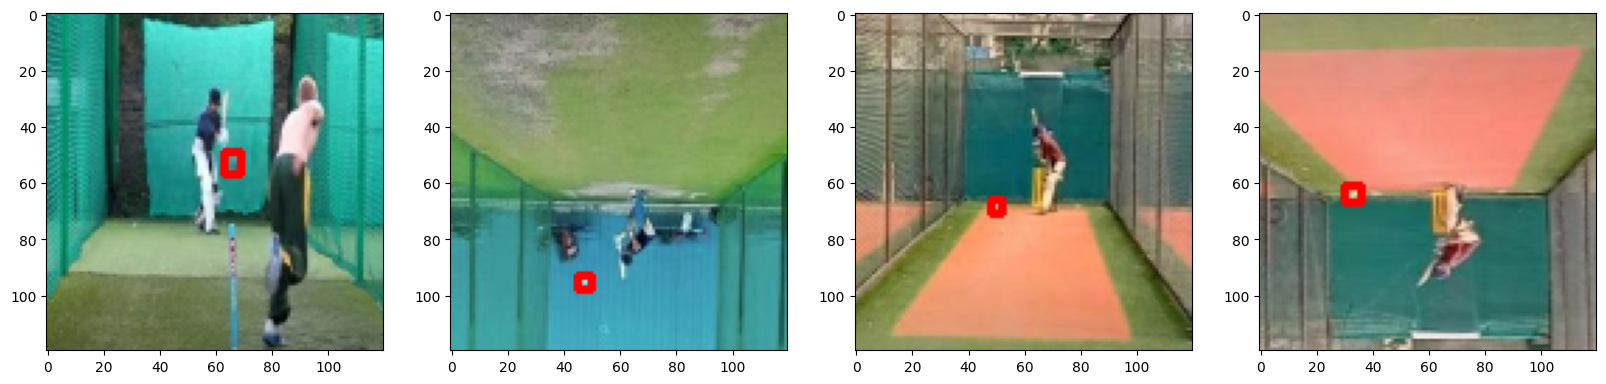

In [27]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [29]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [38]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='tanh')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    balltracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return balltracker

In [40]:
balltracker = build_model()
balltracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = balltracker.predict(X)
classes, coords

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_9[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_6 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

(array([[0.49213535],
        [0.52446175],
        [0.472199  ],
        [0.48204985],
        [0.48389462],
        [0.53839093],
        [0.6107142 ],
        [0.49570405]], dtype=float32),
 array([[0.6783091 , 0.5239342 , 0.7374033 , 0.55970234],
        [0.54991275, 0.5905363 , 0.50400907, 0.6714617 ],
        [0.5494037 , 0.52925473, 0.4213974 , 0.7427886 ],
        [0.6380234 , 0.49439472, 0.4259022 , 0.6165257 ],
        [0.60888976, 0.5830533 , 0.51428896, 0.61113685],
        [0.58138233, 0.5517992 , 0.45188186, 0.64060855],
        [0.6894928 , 0.4982914 , 0.4880785 , 0.66663265],
        [0.53878677, 0.55666167, 0.38394246, 0.64828706]], dtype=float32))

In [41]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [42]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [43]:
localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3911065>

In [44]:
class Balltracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
model =Balltracker(balltracker)
model.compile(opt, classloss, regressloss)

In [45]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5
154/154 [==============================] - 520s 3s/step - total_loss: 0.8854 - class_loss: 0.0275 - regress_loss: 0.8717
Epoch 2/5
154/154 [==============================] - 520s 3s/step - total_loss: 0.7526 - class_loss: 0.0016 - regress_loss: 0.7518
Epoch 3/5
154/154 [==============================] - 520s 3s/step - total_loss: 0.3479 - class_loss: 1.8716e-04 - regress_loss: 0.3478
Epoch 4/5
154/154 [==============================] - 525s 3s/step - total_loss: 0.1119 - class_loss: 6.4562e-05 - regress_loss: 0.1119
Epoch 5/5
154/154 [==============================] - 513s 3s/step - total_loss: 0.0416 - class_loss: 2.9673e-05 - regress_loss: 0.0416


1/1 [==============================] - 1s 786ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


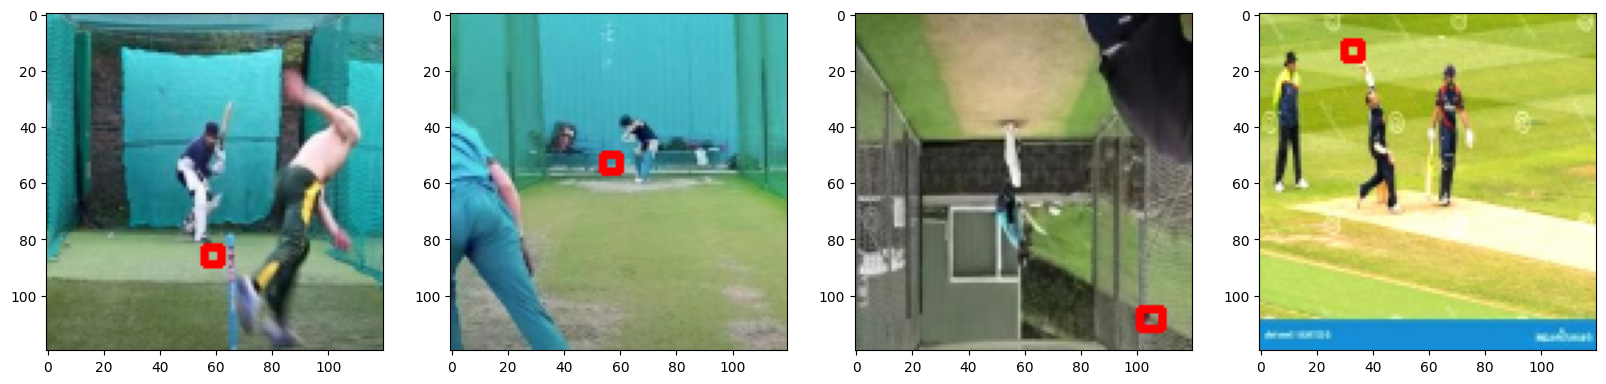

In [48]:
test_data = train.as_numpy_iterator()
test_sample = test_data.next()
yhat = balltracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
yhat
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [49]:
from tensorflow.keras.models import load_model
balltracker.save('ball-detection-v2.h5')